In [ ]:
%pip install dwave-system==1.18.0
%pip install dwave-system[drivers] --extra-index-url https://pypi.dwavesys.com/simple
%pip install dimod==0.11.0
%pip install dwave_qbsolv

%pip install dwave-ocean-sdk>=6.3.0
%pip install mip==1.13.0
%pip install plotly==5.6.0
%pip install streamlit==1.9.2
%pip install tabulate==0.8.9

In [9]:
import os
import time

import networkx as nx
import matplotlib.pyplot as plt

from dwave_qbsolv import QBSolv
from dwave.system import DWaveSampler
import dimod
import hybrid

import MapGraph


In [ ]:
# Get D-Wave token
TOKEN = os.environ['DWAVE_APITOKEN']

# Problem spec
N_CARS = 5
N_ROUTES = 3
ROUTES = []  
STREETS = None

# Dummy - 


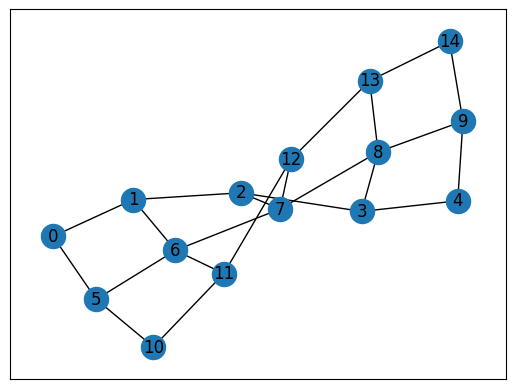

The avenue (0, 1) : permissible speed is 120 km/h **** length is 58 km **** traffic weight is 12 **** it takes time 64.0 minutes
The avenue (0, 5) : permissible speed is 40 km/h **** length is 82 km **** traffic weight is 14 **** it takes time 351.0 minutes
The avenue (1, 2) : permissible speed is 90 km/h **** length is 88 km **** traffic weight is 16 **** it takes time 234.0 minutes
The avenue (1, 6) : permissible speed is 90 km/h **** length is 10 km **** traffic weight is 15 **** it takes time 22.0 minutes
The avenue (2, 3) : permissible speed is 100 km/h **** length is 69 km **** traffic weight is 19 **** it takes time 414.0 minutes
The avenue (2, 7) : permissible speed is 80 km/h **** length is 11 km **** traffic weight is 12 **** it takes time 18.0 minutes
The avenue (3, 4) : permissible speed is 70 km/h **** length is 68 km **** traffic weight is 11 **** it takes time 116.0 minutes
The avenue (3, 8) : permissible speed is 70 km/h **** length is 44 km **** traffic weight is 7 ***

[[(3, 8), (8, 13)],
 [(3, 4), (4, 9), (9, 8), (8, 13)],
 [(3, 8), (8, 9), (9, 14), (14, 13)]]

In [13]:
# Create graph
row = 3
column = 5 

G = MapGraph.make_graph(row, column)
MapGraph.add_traffic_weight(G)
MapGraph.add_time_travel(G)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True)
plt.show()
MapGraph.print_map_graph_details(G)

origin_node = 3
destination_node = 13

# Three shortes paths from origin to destination
paths = MapGraph.find_tre_shortest_paths(G, origin_node, destination_node, overlap=5, weight="time travel")
path_edges = MapGraph.paths_edges(paths)
path_edges

In [ ]:
# classmethod BinaryQuadraticModel.from_qubo(Q: Mapping, offset: float = 0)
#     Q – Coefficients of a quadratic unconstrained binary optimization (QUBO) problem 
#         as a dict of form {(u, v): bias, ...}, where u, v, are binary-valued variables 
#         and bias is their associated coefficient.
#
#     offset (optional, default=0.0) – Constant offset applied to the model.

# QUBO
#   q_ij: car i takes route (= a list of segments) j

def create_cars_variables(n_cars: int, routes: list):
        cars_variables = []

        for i in range(n_cars):
                for j in range(len(routes)):
                        cars_variables.append(f'q{i}{j}')
        return cars_variables

def create_routes_variables(cars_variables: list[str], routes: list, n_routes: int = 3):
        cars_routes = {}

        # Fill routes for car in a cyclic fashion (modulo N_ROUTES = 3)
        for i in range(len(cars_variables)):
                cars_routes[cars_variables[i]] = routes[route_index]


cars_vars = create_cars_variables(N_CARS, ROUTES)

cars_routes = create_routes_variables(cars_vars, routes, N_ROUTES)


